<a href="https://colab.research.google.com/github/manish26m/sentimentalAnalysis_onSocialMedia/blob/main/Sentimental_Analysis_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Dataset**

In [2]:
from IPython import get_ipython
from IPython.display import display


In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
import pandas as pd



file_path = "/content/drive/My Drive/Colab Notebooks/Twitter_Data.csv"
df = pd.read_csv(file_path)

# Display basic info
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


# **Data Cleaning (Stopwords, URLs, Mentions, Hashtags, Special Characters)**

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# Remove missing values
df.dropna(subset=['clean_text', 'category'], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)


In [8]:
# Convert category column to integer
df['category'] = df['category'].astype(int)


In [9]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [10]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords & lemmatize
    return " ".join(tokens)

In [11]:
import nltk
nltk.download('punkt_tab')
# Apply cleaning function
df['clean_text'] = df['clean_text'].apply(clean_text)

# Check cleaned text
print(df[['clean_text', 'category']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                          clean_text  category
0  modi promised minimum government maximum gover...        -1
1             talk nonsense continue drama vote modi         0
2  say vote modi welcome bjp told rahul main camp...         1
3  asking supporter prefix chowkidar name modi gr...         1
4  answer among powerful world leader today trump...         1


# Exploratory Data Analysis (EDA)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


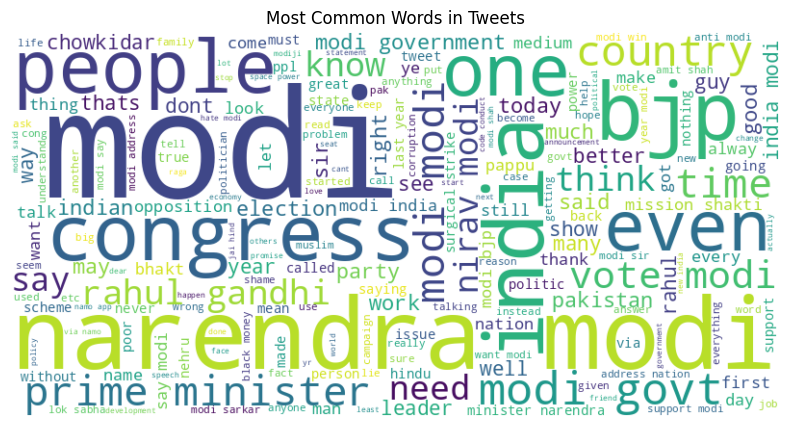

In [13]:
# WordCloud of most frequent words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['clean_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Tweets")
plt.show()

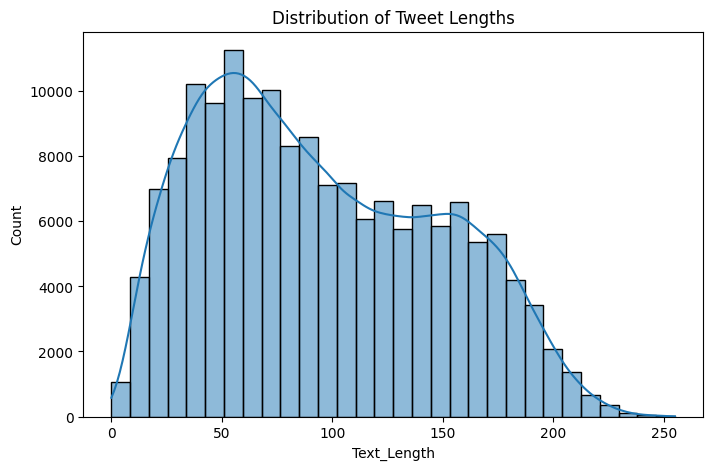

In [14]:
# Check text length distribution
df['Text_Length'] = df['clean_text'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths")
plt.show()

# Sentiment Analysis Using NLP (VADER)

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [16]:
# Download VADER
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [17]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [18]:
# Function to get sentiment scores
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"

df['Sentiment'] = df['clean_text'].apply(get_sentiment)

<ipython-input-19-c1c186bb7747>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Sentiment'], palette="viridis")


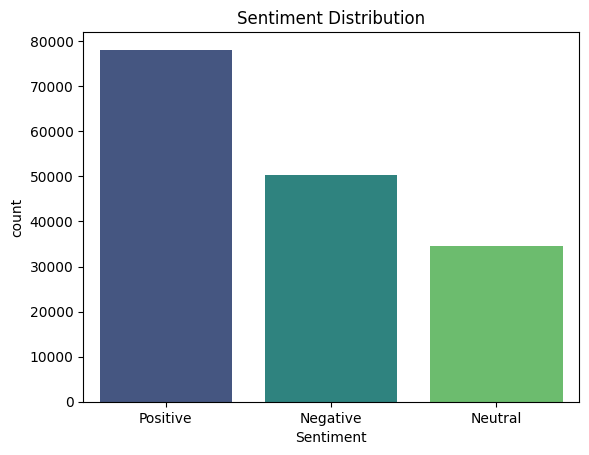

In [19]:
# Sentiment distribution
sns.countplot(x=df['Sentiment'], palette="viridis")
plt.title("Sentiment Distribution")
plt.show()


# Machine Learning-Based Sentiment Classification

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [21]:
# Convert text data into numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['Sentiment']

In [22]:
# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Train model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [25]:
# Predict on test set
y_pred = model.predict(X_test)

In [26]:
# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7051911394735227
              precision    recall  f1-score   support

    Negative       0.83      0.64      0.72     10124
     Neutral       0.78      0.29      0.42      6862
    Positive       0.65      0.93      0.77     15608

    accuracy                           0.71     32594
   macro avg       0.75      0.62      0.64     32594
weighted avg       0.73      0.71      0.68     32594



# Big Data Processing Using PySpark

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression

In [28]:
# Initialize Spark
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

In [29]:
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df[['clean_text', 'category']])


In [30]:
# Tokenization
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
spark_df = tokenizer.transform(spark_df)


In [31]:
# Remove Stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
spark_df = remover.transform(spark_df)

In [32]:
# TF-IDF Feature Extraction
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
tf = hashingTF.transform(spark_df)
idf = IDF(inputCol="rawFeatures", outputCol="features").fit(tf)
spark_df = idf.transform(tf)

In [33]:
# Train Logistic Regression Model
from pyspark.sql.functions import when

# Replace -1 with 0 in the 'category' column
spark_df = spark_df.withColumn("category", when(col("category") == -1, 0).otherwise(col("category")))

# Now proceed with training the Logistic Regression model
lr = LogisticRegression(labelCol="category", featuresCol="features")
model = lr.fit(spark_df)

In [34]:
# Show processed data
spark_df.select("clean_text", "category").show(5)


+--------------------+--------+
|          clean_text|category|
+--------------------+--------+
|modi promised min...|       0|
|talk nonsense con...|       0|
|say vote modi wel...|       1|
|asking supporter ...|       1|
|answer among powe...|       1|
+--------------------+--------+
only showing top 5 rows



# Build a Dashboard with Streamlit

In [35]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [81]:
import os
import time
from pyngrok import ngrok


In [90]:
ngrok.set_auth_token("2v5jHlrypJ0Lt4YCAtQk4jihxur_7q7hYTNn3FuTv9RYNJBqB")

In [86]:
%%writefile app.py
import streamlit as st

def get_sentiment(text):
    return "Positive"  # Replace with actual sentiment analysis logic

st.title("Social Media Sentiment Analysis")
user_input = st.text_area("Enter a social media post:")

if st.button("Analyze Sentiment"):
    sentiment = get_sentiment(user_input)
    st.write(f"Predicted Sentiment: {sentiment}")


Overwriting app.py


In [91]:
!streamlit run app.py &> logs.txt &


In [97]:
ngrok.disconnect(public_url.public_url)
time.sleep(5)
#The port should be within the addr parameter.
public_url = ngrok.connect(addr='8501')
print(f"Streamlit App is running on {public_url}")


Streamlit App is running on NgrokTunnel: "https://f18a-34-106-104-79.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!curl https://loca.lt/mytunnelpassword

35.194.154.176

In [99]:
!pkill -f streamlit



In [100]:
!streamlit run app.py &> logs.txt &


In [103]:
from pyngrok import ngrok

# Kill any existing ngrok processes to ensure you start fresh
ngrok.kill()

# Connect to ngrok, specifying the port using 'addr'
public_url = ngrok.connect(addr='8501')
print(f"New Streamlit App URL: {public_url}")

ERROR:pyngrok.process.ngrok:t=2025-03-31T18:20:36+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to send authentication request: tls: first record does not look like a TLS handshake"


New Streamlit App URL: NgrokTunnel: "https://6515-34-106-104-79.ngrok-free.app" -> "http://localhost:8501"


# Use Generative AI for Automatic News Summaries

In [104]:
from transformers import pipeline


In [106]:
summarizer = pipeline("summarization")


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [112]:
# Summarizing most discussed topics
text_to_summarize = " ".join(df['clean_text'][:10])  # Example with 10 posts
summary = summarizer(text_to_summarize, max_length=100, min_length=30, do_sample=False)

In [111]:
print("Generated News Summary:")
print(summary[0]['summary_text'])


Generated News Summary:
 modi promised minimum government maximum governance expected begin difficult job reforming state take year get justice state business exit psus temple . modi promises minimum government minimum governance expected .
